grupa: poniedziałek

członkowie zespołu: Franek Sakowski i Miłosz Łopatto

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

# read training data

In [2]:
df = pd.read_csv('data.csv')
test_df = pd.read_csv('evaluation_data.csv')

## EDA and visualizations

In [3]:
# sns.pairplot(data)

/var/folders/v7/7b5vyv797kg9pf47h5zx_wxr0000gn/T/ipykernel_63273/1290743455.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), square=True, cmap='RdYlGn')


<AxesSubplot: >

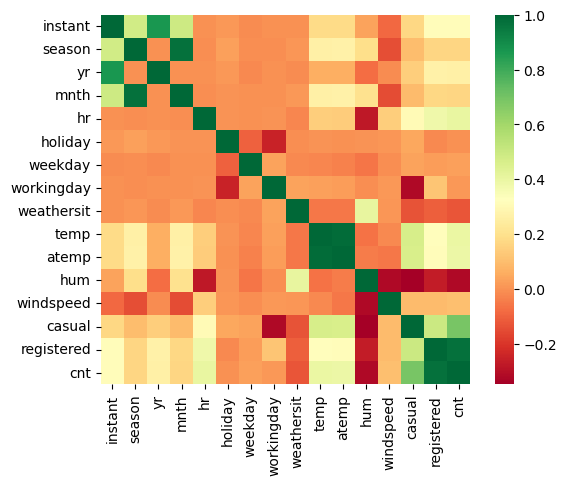

In [4]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [5]:
df = df.drop(columns=['dteday', 'instant'])
test_df = test_df.drop(columns='dteday')

In [6]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,12,19,0,3,1,1,0.38,0.3939,0.50,0.3881,7,329,336
10882,4,1,12,20,0,3,1,1,0.36,0.3485,0.57,0.2239,10,231,241
10883,4,1,12,21,0,3,1,1,0.34,0.3182,0.61,0.2239,4,164,168
10884,4,1,12,22,0,3,1,1,0.34,0.3485,0.61,0.0896,12,117,129


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   yr          10886 non-null  int64  
 2   mnth        10886 non-null  int64  
 3   hr          10886 non-null  int64  
 4   holiday     10886 non-null  int64  
 5   weekday     10886 non-null  int64  
 6   workingday  10886 non-null  int64  
 7   weathersit  10886 non-null  int64  
 8   temp        10886 non-null  float64
 9   atemp       10886 non-null  float64
 10  hum         10886 non-null  float64
 11  windspeed   10886 non-null  float64
 12  casual      10886 non-null  int64  
 13  registered  10886 non-null  int64  
 14  cnt         10886 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 1.2 MB


In [8]:
df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.501929,6.521495,11.541613,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,36.021955,155.552177,191.574132
std,1.116174,0.500019,3.444373,6.915838,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,49.960477,151.039033,181.144454
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,36.000000,42.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000,118.000000,145.000000
75%,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000,222.000000,284.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,367.000000,886.000000,977.000000


# Constants

In [9]:
USE_MPS_GPU = True  # device whether to use MPS gpu if available

# Connect to GPU if available

In [10]:
import platform

platform.platform()

'macOS-12.6-arm64-arm-64bit'

In [11]:
if torch.has_mps and USE_MPS_GPU:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [12]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

if torch.backends.mps.is_available() and USE_MPS_GPU:
    # torch.backends.mps.manual_seed(42)
    # torch.backends.mps.manual_seed_all(42)
    pass
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

# Prepare data

## Convert all values into float

In [13]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,12,19,0,3,1,1,0.38,0.3939,0.50,0.3881,7,329,336
10882,4,1,12,20,0,3,1,1,0.36,0.3485,0.57,0.2239,10,231,241
10883,4,1,12,21,0,3,1,1,0.34,0.3182,0.61,0.2239,4,164,168
10884,4,1,12,22,0,3,1,1,0.34,0.3485,0.61,0.0896,12,117,129


In [14]:
df = df.astype(float)
test_df = test_df.astype(float)

## Scale all values

In [15]:
quality_backup = df[['casual', 'registered', 'cnt']]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled[['casual', 'registered', 'cnt']] = quality_backup #restore quality values

In [16]:
scaler = MinMaxScaler()
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns = test_df.columns)

In [17]:
df_scaled.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.502205,0.501929,0.501954,0.501809,0.028569,0.499770,0.680875,0.139476,0.483098,0.512252,0.618865,0.224563,36.021955,155.552177,191.574132
std,0.372058,0.500019,0.313125,0.300689,0.166599,0.334628,0.466159,0.211280,0.193917,0.189610,0.192450,0.143245,49.960477,151.039033,181.144454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.333333,0.000000,0.272727,0.260870,0.000000,0.166667,0.000000,0.000000,0.326531,0.355856,0.470000,0.122840,4.000000,36.000000,42.000000
50%,0.666667,1.000000,0.545455,0.521739,0.000000,0.500000,1.000000,0.000000,0.489796,0.525338,0.620000,0.228047,17.000000,118.000000,145.000000
75%,1.000000,1.000000,0.818182,0.782609,0.000000,0.833333,1.000000,0.333333,0.632653,0.677928,0.770000,0.298225,49.000000,222.000000,284.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,367.000000,886.000000,977.000000


In [18]:
row_index_threshold = round(0.8 * len(df.index))
train = df_scaled.iloc[:row_index_threshold]
val = df_scaled.iloc[row_index_threshold:]

In [19]:
print(train.shape)
print(val.shape)

(8709, 15)
(2177, 15)


## Split features and labels

In [20]:
X_train, y_train_casual, y_train_registered, y_train_cnt = train.drop(['casual', 'registered', 'cnt'], axis=1), train['casual'], train['registered'], train['cnt']
print(X_train.shape)

X_val, y_val_casual, y_val_registered, y_val_cnt = val.drop(['casual', 'registered', 'cnt'], axis=1), val['casual'], val['registered'], val['cnt']
print(X_val.shape)

X_test = test_df
print(X_test.shape)

(8709, 12)
(2177, 12)
(6493, 12)


### Split into batches

In [21]:
f=40 # number of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train_cnt, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val_cnt, f)

test_batch = np.array_split(X_test, f)

for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)

for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
    
print("Batch size:", len(train_batch[0]))


Batch size: 218


/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/numpy/lib/shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


## The Model

In [22]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(12, 24)
        self.fc2 = nn.Linear(24, 96)
        self.fc3 = nn.Linear(96, 192)
        self.fc4 = nn.Linear(192, 384)
        self.fc5 = nn.Linear(384, 96)
        self.fc6 = nn.Linear(96, 24)
        self.fc7 = nn.Linear(24, 1)


        self.dropout = nn.Dropout(0.10)
       
    def forward(self, x):
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))

        return x

model = Regressor()
train_losses, val_losses = [], []
# criterion = nn.MSELoss()
# create a function (this my favorite choice)
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=15) 
total_epochs=0

## The training loop

In [23]:
best_model = copy.deepcopy(model)
best_val_loss = None

In [24]:
#print(model)
epochs = 100
total_epochs+=epochs

model.train()

for e in tnrange(epochs):
    
    train_loss = 0
    val_loss_1 = 0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        train_batch = train_batch
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
    # saving best model
    val_loss_divided = val_loss_sum/len(val_batch)
    if best_val_loss is None or val_loss_divided < best_val_loss:
        print('Model replaced')
        best_val_loss = val_loss_divided
        best_model = copy.deepcopy(model)
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_divided)    
    val_losses.append(val_loss_divided)    
    train_losses.append(train_loss/len(train_batch))   

/var/folders/v7/7b5vyv797kg9pf47h5zx_wxr0000gn/T/ipykernel_63273/1377750946.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for e in tnrange(epochs):


  0%|          | 0/100 [00:00<?, ?it/s]

Model replaced
Epoch : 0 train_loss : 198.75416526794433 Val loss:  305.19127163887026
Model replaced
Epoch : 1 train_loss : 184.56821956634522 Val loss:  248.79814230918882
Model replaced
Epoch : 2 train_loss : 166.6061689376831 Val loss:  229.32018431663514
Model replaced
Epoch : 3 train_loss : 161.13369140625 Val loss:  225.1526041507721
Model replaced
Epoch : 4 train_loss : 156.7590528488159 Val loss:  220.55905886650083
Model replaced
Epoch : 5 train_loss : 151.82395191192626 Val loss:  216.53793829917907
Model replaced
Epoch : 6 train_loss : 148.1895498275757 Val loss:  212.5694363975525
Model replaced
Epoch : 7 train_loss : 144.59035358428955 Val loss:  210.01259648323057
Model replaced
Epoch : 8 train_loss : 142.1198263168335 Val loss:  209.30740860462188
Model replaced
Epoch : 9 train_loss : 141.05312490463257 Val loss:  208.69496704101562
Model replaced
Epoch : 10 train_loss : 139.51615772247314 Val loss:  206.81387674331663
Model replaced
Epoch : 11 train_loss : 138.22427873

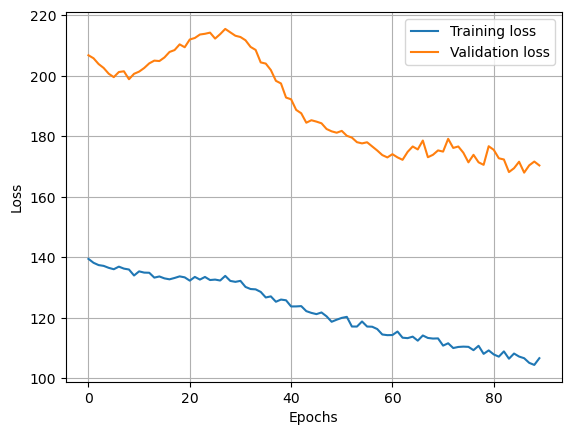

In [25]:
### Training Metrics :
frm=10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### save model

In [26]:
state_dict = model.state_dict()
torch.save(state_dict, "saved_model.tar")

### save predictions

In [27]:
model_used = best_model

In [28]:
test_outputs = []
for j in range(len(test_batch)):
    print()
    test_output = model_used(test_batch[j])
    print(len(test_output.unsqueeze(dim=1)))
    for value in test_output:
        test_outputs.append(value)
    print(len(test_outputs))


163
163

163
326

163
489

163
652

163
815

163
978

163
1141

163
1304

163
1467

163
1630

163
1793

163
1956

163
2119

162
2281

162
2443

162
2605

162
2767

162
2929

162
3091

162
3253

162
3415

162
3577

162
3739

162
3901

162
4063

162
4225

162
4387

162
4549

162
4711

162
4873

162
5035

162
5197

162
5359

162
5521

162
5683

162
5845

162
6007

162
6169

162
6331

162
6493


In [29]:
list_output = []
for output in test_outputs:
    list_output.append(output.item())

In [30]:
df_output = pd.DataFrame(list_output)
df_output

,0
0,48.730579
1,24.182333
2,23.557579
3,18.427410
4,23.482477
...,...
6488,565.579590
6489,388.279144
6490,165.288300
6491,357.552948


In [31]:
df_output.to_csv('muchomorki.csv', header=False, index=False)